# Full waveform inversion exercise

In this exercise we look at a 2D example of full waveform inversion. 
For our example we use synthetic data generated in a computer generated velocity model. The Marmousi model was created in 1988 by the Institut Francais du Pétrole (IFP). The model is based on a real profile through the North Quenguela trough in the Kwanza basin (offshore Angola). The geometry and velocity model were created to produce complex seismic data which require advanced processing techniques to obtain a correct Earth image. Traditional traveltime tomography is not suited to recover the detailed velocity information conatined in the model.
The Marmousi model has been used extensively for testing of new methods and approaches for Earth imaging, not restricted to waveform inversion.

You will not be running the inversion in real time. This would be too time consuming and complex to set up for the whole class. Instead the inversion has been run in advance on Imperial College's HPC cluster. This took only a few minutes, using 2 nodes, each runnning 24 processes. Large 3D inversions can take several days to run and require hundreds of compute nodes.

The waveform modelling and inversion is done using Fullwave3d, a code developed at Imperial College by the Fullwave group, led by Mike Warner (https://fullwave3d.github.io/).

In [78]:
# Set up Python environment
import segyio
import numpy as np
import matplotlib.pyplot as plt
import re

# Experiment geometry

here we read some parameters defining the experiment geometry

In [79]:
# Name of project
project='Marm2D'
# Read inversion and model parameters
runfile=project+'-Runfile.key'

# Open file and read parameters
with open(runfile) as f:
    text = f.readlines()
    for line in text:
        if 'NSHOT' in line: nshot = np.int(line.split(':')[-1])
        if 'NRECS' in line: nrecs = np.int(line.split(':')[-1])
        if 'NX1' in line: nx1 = np.int(line.split(':')[-1])
        if 'NX3' in line: nx3 = np.int(line.split(':')[-1])
        if 'DX' in line: dx = np.float(line.split('!')[0].split(':')[-1])

print("Number of sources:",nshot)
print("Number of receivers:",nrecs)
print("Number x nodes:",nx1)
print("Number z nodes:",nx3)
print("Grid spacing:",dx,"m")

Number of sources: 15
Number of receivers: 371
Number x nodes: 384
Number z nodes: 136
Grid spacing: 24.0 m


# Source wavelet

This is the source time function. At each source location we inject a pressure perturbation.

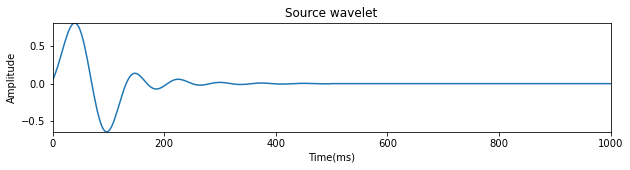

In [80]:
# Read source wavelet
filename='Marm2D-RawSign.sgy'
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    time = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
    trace=data[0]
# Plot source wavelet
    fig = plt.figure(figsize=(10, 2))
    ax = fig.add_subplot(111)
    ax.plot(time,trace)
    ax.set_xlim(0,1000)
    ax.set_ylim(np.min(trace),np.max(trace))
    ax.set_xlabel('Time(ms)')
    ax.set_ylabel('Amplitude')
    ax.set_title('Source wavelet')

# Plot the data

We use synthetic data generated by solving the forward problem (the acoustic wave equation) in the true velocity model. We will call this the "field data" in the rest of the exercise but remember that it is not real data. This is similar to what we did in the travel time exercise, where our "data" was also generated through the true model.

N Traces: 5565, N Samples: 1250, Sample rate: 2.4ms
The 99th percentile is 1; the max amplitude is 82


Text(0.5, 1.0, 'Shot number 6')

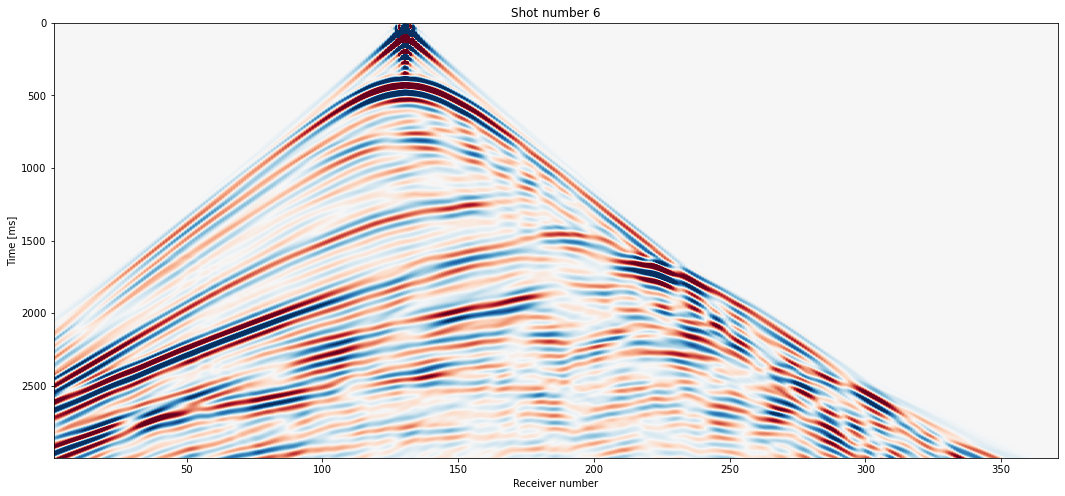

In [81]:
# Data filename
filename='Marm2D-Synthetic.sgy'
# Open data file
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    n_traces = f.tracecount
    sample_rate = segyio.tools.dt(f) / 1000
    n_samples = f.samples.size
    time = f.samples
    data = f.trace.raw[:]  # Get all data into memory (could cause on big files)
print(f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms')
# Select amplitude cutoff for plotting
clip_percentile = 99
vm = np.percentile(data, clip_percentile)
print(f'The {clip_percentile}th percentile is {vm:.0f}; the max amplitude is {data.max():.0f}')

# Select shot to plot
shot=6
trace1=nrecs*(shot-1)
trace2=nrecs*shot

# Plot shot gather
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1, 1, 1)
extent = [1, nrecs, time[-1], time[0]]  # define extent
ax.imshow(data.T[:,trace1:trace2], cmap="RdBu", vmin=-vm, vmax=vm, aspect='auto',extent=extent)
ax.set_xlabel('Receiver number')
ax.set_ylabel('Time [ms]')
ax.set_title(f'Shot number {shot}')

# True model and starting model

The true model is the Marmousi model. The starting model in this case is obtained by smoothing the true model and adding a small bias. In real cases the starting model may be generated by travel time tomography or from the stacking velocities from processing of reflection data.

Text(0.5, 1.0, 'Starting model')

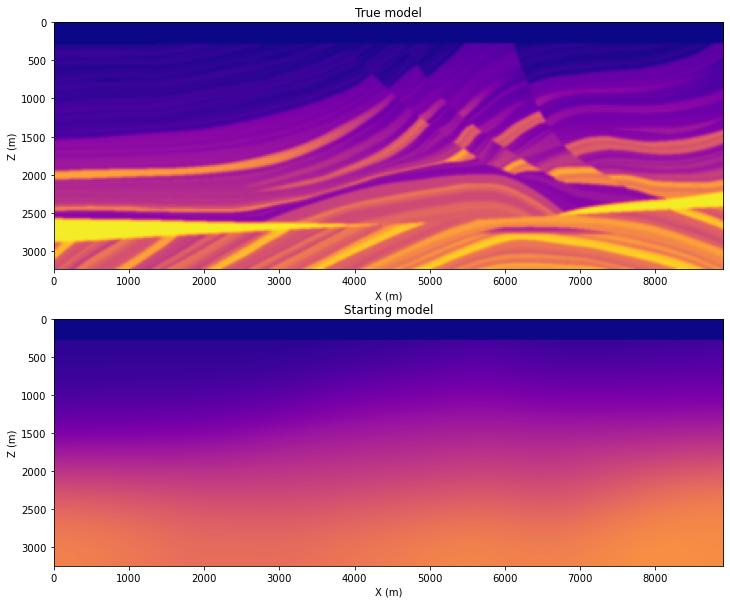

In [82]:
filename='Marm2D-TrueVp.sgy'
with segyio.open(filename, ignore_geometry=True) as f:
    vptrue = f.trace.raw[:]  # Get all data into memory (could cause issues on big files)

filename='Marm2D-StartVp.sgy'
with segyio.open(filename, ignore_geometry=True) as f:
    depth = f.samples
    vpstart = f.trace.raw[:]  # Get all data into memory (could cause issues on big files)

#print(f'N Traces: {n_traces}, N Samples: {n_samples}, Sample rate: {sample_rate}ms')

fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(2, 1, 1)
extent = [0, nrecs*dx, depth[-1], depth[0]]  # define extent
ax1.imshow(vptrue.T, cmap="plasma", vmin=1500, vmax=5000, aspect='auto',extent=extent)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Z (m)')
ax1.set_title('True model')

ax2 = fig.add_subplot(2, 1, 2)
extent = [0, nrecs*dx, depth[-1], depth[0]]  # define extent
ax2.imshow(vpstart.T, cmap="plasma", vmin=1500, vmax=5000, aspect='auto',extent=extent)
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Z (m)')
ax2.set_title('Starting model')

# Add color scale

# The wavefield

The wavefield describes the pressure field generated by the source. Below we read and plot the wavefield for shot number 6 calculate in the starting model.

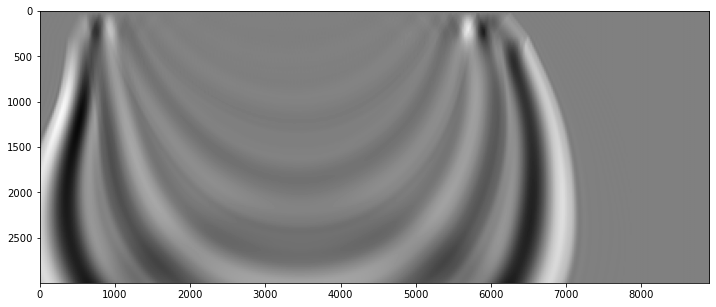

In [83]:
%matplotlib inline
from IPython.display import clear_output
from time import sleep

xtratop=0
xtrabot=50
xtra1=50
nx3w=nx3+xtratop+xtrabot
nx1w=nx1+2*xtra1

extent = [0, nrecs*dx, time[-1], time[0]]  # define extent
timesteps=np.arange(20,800,20,dtype=int)
#timesteps=np.arange(1240,500,-20,dtype=int)

iteration=1
iterstr=str(iteration).zfill(5)
shotstr=str(shot).zfill(5)
xcorr=np.zeros((nx1,nx3))
for step in timesteps:
    fig = plt.figure(figsize=(12, 5))
    timestr=str(step).zfill(6)
    filename='fw-'+timestr+'-csref'+shotstr+'-iter'+iterstr+'fwd1.vtr'
    !../VTR/read_vtr <<< {filename} >& tmp
    binfile=filename+".bin"
    fw=np.fromfile(binfile, dtype=np.float32)
    fw=np.reshape(fw,(nx1w,nx3w))
    fw=fw[xtra1:-xtra1,xtratop:-xtrabot]
    clear_output(wait=True)
    plt.imshow(fw.T, cmap="gray",vmin=-70,vmax=70,aspect='auto',extent=extent)
    plt.show()
    sleep(0.03)

# Data misfit (residuals)

The wavefield is defined everywhere in the model. We are interested in the value fo the wavefield at the receivers, so we extract the wavefield at these locations. This gives us shot gathers that we can compare to the data. Below we plot the syntehtics, data and residuals. The residuals are simply calculated by subdtracting the data from the synthetics. Notice how the synthetics are much simpler and don't contain all the complicated reflections seen in the data.

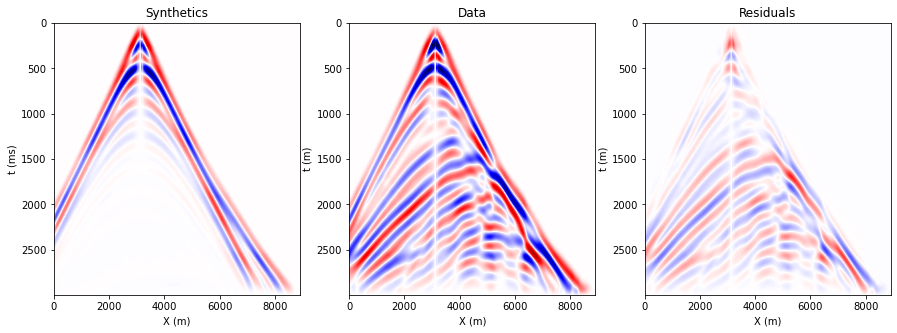

In [84]:

ntraces=nrecs*3
x1=0
x2=371

for step in ["01"]:
    filename='compare_6_'+step+'.bin'
    traces=np.fromfile(filename, dtype=np.float32)
    traces=np.reshape(traces,(ntraces,n_samples))
    

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 3, 1)
    extent = [x1, x2*dx, time[-1], time[0]]  # define extent
    ax1.imshow(traces.T[:,x1:x2], cmap="seismic",vmin=-0.1,vmax=0.1,aspect='auto',extent=extent)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('t (ms)')
    ax1.set_title('Synthetics')
    ax1 = fig.add_subplot(1, 3, 2)
    extent = [x1, x2*dx, time[-1], time[0]]  # define extent
    ax1.imshow(traces.T[:,nrecs+x1:nrecs+x2], cmap="seismic",vmin=-0.1,vmax=0.1,aspect='auto',extent=extent)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('t (m)')
    ax1.set_title('Data')
    ax1 = fig.add_subplot(1, 3, 3)
    extent = [x1, x2*dx, time[-1], time[0]]  # define extent
    ax1.imshow(traces.T[:,2*nrecs+x1:2*nrecs+x2], cmap="seismic",vmin=-0.2,vmax=0.2,aspect='auto',extent=extent)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('t (m)')
    ax1.set_title('Residuals')

# Trace comparison

The mismatch between data and synthetics can also be seen by plotting one of the traces as a wiggle. Below we plot the data in balck and the synthetics in blue. Notice how the first couple of peaks are predicted reasonably well, this correpsonds to the refracted arrivals. The later arrivals are not present in the synthetics because there are no sharp boundaries to generate the reflections.

Text(0.5, 1.0, 'Trace comparison')

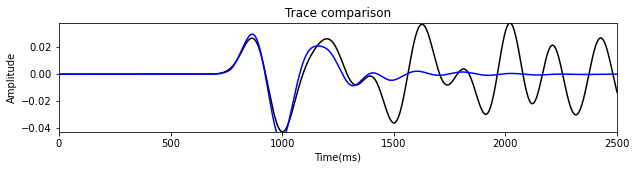

In [85]:
tracenum=180
datatrace=traces[nrecs+tracenum,:]
syntrace=traces[tracenum,:]

fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot(111)
ax.plot(time,datatrace,'black')
ax.plot(time,syntrace,'blue')

ax.set_xlim(0,2500)
ax.set_ylim(np.min(datatrace),np.max(datatrace))
ax.set_xlabel('Time(ms)')
ax.set_ylabel('Amplitude')
ax.set_title('Trace comparison')


# The residual wavefield

To compute the gradient ob the objective function we need to first calculate the back-propagate residual wavefield. this consists of turning the receivers into sources and the residuals into source time functions.

Notice how all othe receivers act as sources at the same time. This is done to save computational cost.


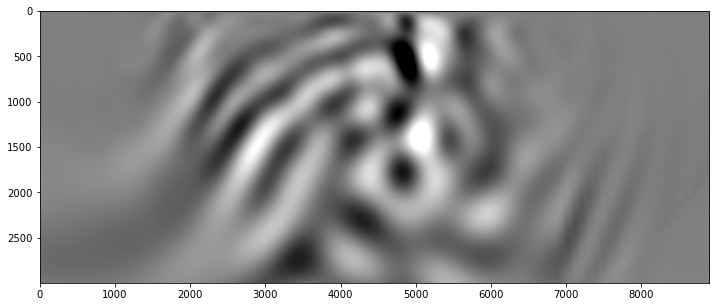

In [86]:
%matplotlib inline
from IPython.display import clear_output
from time import sleep

xtratop=0
xtrabot=50
xtra1=50
nx3w=nx3+xtratop+xtrabot
nx1w=nx1+2*xtra1

extent = [0, nrecs*dx, time[-1], time[0]]  # define extent
timesteps=np.arange(1240,500,-20,dtype=int)

iteration=1
iterstr=str(iteration).zfill(5)
shotstr=str(shot).zfill(5)
xcorr=np.zeros((nx1,nx3))
for step in timesteps:
    fig = plt.figure(figsize=(12, 5))
    timestr=str(step).zfill(6)
    filename='bw-'+timestr+'-csref'+shotstr+'-iter'+iterstr+'fwd1.vtr'
    !../VTR/read_vtr <<< {filename} >& tmp
    binfile=filename+".bin"
    bw=np.fromfile(binfile, dtype=np.float32)
    bw=np.reshape(bw,(nx1w,nx3w))
    bw=bw[xtra1:-xtra1,xtratop:-xtrabot]
    clear_output(wait=True)
    plt.imshow(bw.T, cmap="gray",vmin=-0.1,vmax=0.1,aspect='auto',extent=extent)
    plt.show()
    sleep(0.03)

# Cross-correlation

The cross-correlation consists in multiply the forward and residual wavefields at each time step and the summing al the timesteps together. First we look at the product of the forward and residual fields:

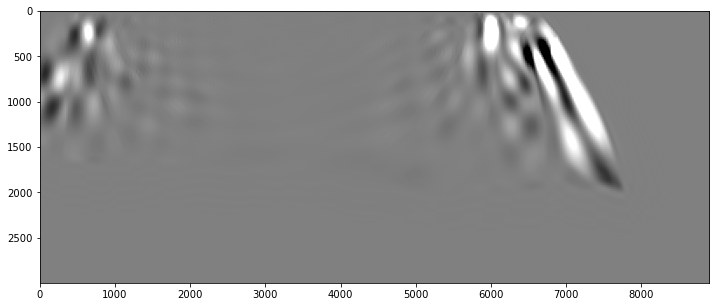

In [88]:
%matplotlib inline
from IPython.display import clear_output
from time import sleep

xtratop=0
xtrabot=50
xtra1=50
nx3w=nx3+xtratop+xtrabot
nx1w=nx1+2*xtra1

extent = [0, nrecs*dx, time[-1], time[0]]  # define extent
timesteps=np.arange(20,880,20,dtype=int)
#timesteps=np.arange(1240,500,-20,dtype=int)

iteration=1
iterstr=str(iteration).zfill(5)
shotstr=str(shot).zfill(5)
xcorr=np.zeros((nx1,nx3))
for step in timesteps:
    fig = plt.figure(figsize=(12, 5))
    timestr=str(step).zfill(6)
    filename='fw-'+timestr+'-csref'+shotstr+'-iter'+iterstr+'fwd1.vtr'
    !../VTR/read_vtr <<< {filename} >& tmp
    binfile=filename+".bin"
    fw=np.fromfile(binfile, dtype=np.float32)
    fw=np.reshape(fw,(nx1w,nx3w))
    fw=fw[xtra1:-xtra1,xtratop:-xtrabot]
    filename='bw-'+timestr+'-csref'+shotstr+'-iter'+iterstr+'fwd1.vtr'
    !../VTR/read_vtr <<< {filename} >& tmp
    binfile=filename+".bin"
    bw=np.fromfile(binfile, dtype=np.float32)
    bw=np.reshape(bw,(nx1w,nx3w))
    bw=bw[xtra1:-xtra1,xtratop:-xtrabot]
    prod=bw*fw
    xcorr+=prod
    clear_output(wait=True)
    plt.imshow(prod.T, cmap="gray",vmin=-1,vmax=1,aspect='auto',extent=extent)
    plt.show()
    sleep(0.03)
    

Here we look at the summed contribution of all time steps for on of the sources

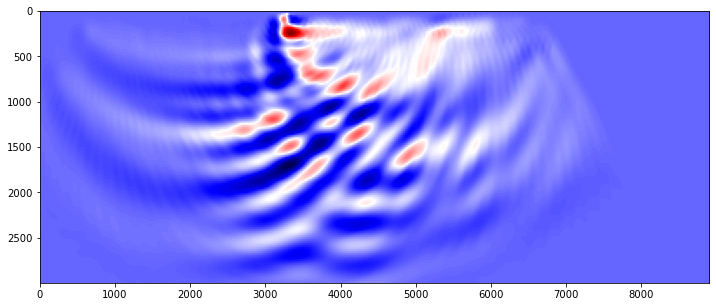

In [89]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 1, 1)
extent = [0, nrecs*dx, time[-1], time[0]]  # define extent
plt.imshow(xcorr.T, cmap="seismic",aspect='auto',extent=extent)

# The gradient

If we sum together the contributions of all sources we get the gradient or the unscaled model update.

 vtr file name?
           1           2
         187         484
0.089824155


Text(0.5, 1.0, 'Gradient')

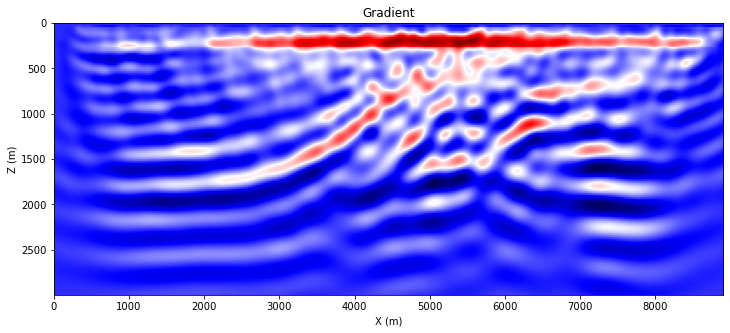

In [96]:
iteration=1
iterstr=str(iteration).zfill(5)
filename='Marm2D-CP'+iterstr+'-Grad.vtr'
!../VTR/read_vtr <<< {filename}

xtratop=1
xtrabot=50
xtra1=50
nx3w=nx3+xtratop+xtrabot
nx1w=nx1+2*xtra1

binfile=filename+".bin"
grad=np.fromfile(binfile, dtype=np.float32)
grad=np.reshape(grad,(nx1w,nx3w))
grad=grad[xtra1:-xtra1,xtratop:-xtrabot]

print(np.max(grad))

fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 1, 1)
extent = [0, nrecs*dx, time[-1], time[0]]  # define extent
ax1.imshow(grad.T, cmap="seismic",aspect='auto',extent=extent)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Z (m)')
ax1.set_title('Gradient')

# The step length

After we calculate the gradient we can add a small perturbation to the starting model in the direction of the gradient. We then solve the forward problem one more time (recalculate the synthetic data) and recomputer the residuals. This helps us determine then step length, i.e. the optimal magnitude of the model update. 

Once we have the step length we can update the model.

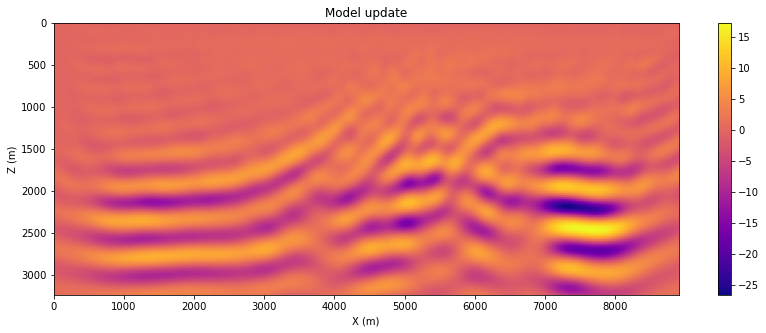

In [109]:
iteration=1
iterstr=str(iteration).zfill(5)
filename='Marm2D-CP'+iterstr+'-InvVp-Update.sgy'
# Read the slowness update
with segyio.open(filename, ignore_geometry=True) as f:
    slowupdate = f.trace.raw[:] 
    depth = f.samples
filename='Marm2D-CP'+iterstr+'-Vp.sgy'

# Read Vp the model
with segyio.open(filename, ignore_geometry=True) as f:
    vp = f.trace.raw[:] 
    depth = f.samples
# Calculate the Vp update
vpupdate=slowupdate*vp*vp
    
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(1, 1, 1)
extent = [0, nrecs*dx, depth[-1], depth[0]]  # define extent
im=ax1.imshow(vpupdate.T, cmap="plasma", aspect='auto',extent=extent)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Z (m)')
ax1.set_title('Model update')
fig.colorbar(im)

# Iteration procedure

Once we have updated the model we can iterate. In this case we have run 120 iterations. These are divided into blocks of 20 iterations. In each block we have increased the frequency of the signal that we allow, starting only with low frequencies. This ensures that we avoid cycle skipping and falling into local minima. 

# Output velocity models

We can then have a look at how the starting model has changed. The box below will plot a comparison of the true model and output model. You can change the variable iternum to plot the output model for different steps (choose for example iterations 20, 40, 60, 80, 100, 120. 


Text(0.5, 1.0, 'Iteration 00001')

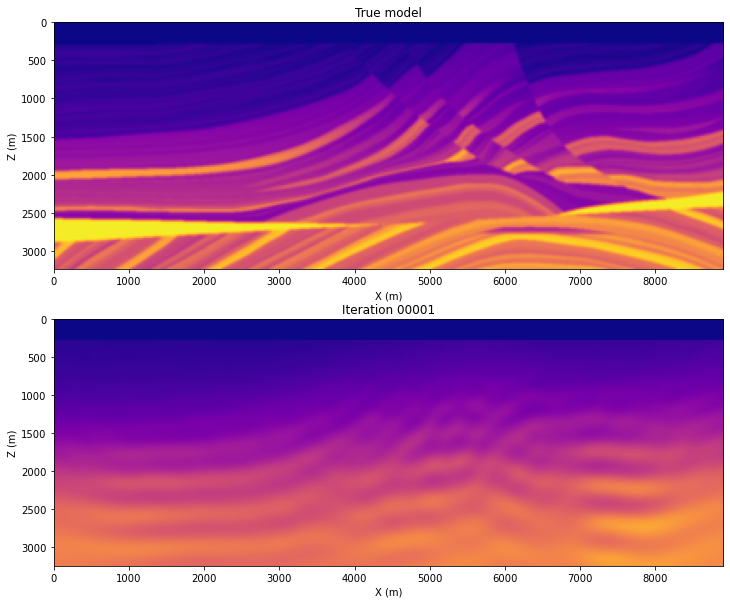

In [91]:
iternum=1

filename='Marm2D-TrueVp.sgy'
with segyio.open(filename, ignore_geometry=True) as f:
    vptrue = f.trace.raw[:]  # Get all data into memory (could cause issues on big files)

iterstr=str(iternum).zfill(5)
filename='Marm2D-CP'+iterstr+'-Vp.sgy'
with segyio.open(filename, ignore_geometry=True) as f:
    # Get basic attributes
    depth = f.samples
    vpstart = f.trace.raw[:]  # Get all data into memory (could cause issues on big files)

fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(2, 1, 1)
extent = [0, nrecs*dx, depth[-1], depth[0]]  # define extent
ax1.imshow(vptrue.T, cmap="plasma", vmin=1500, vmax=5000, aspect='auto',extent=extent)
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Z (m)')
ax1.set_title('True model')

ax2 = fig.add_subplot(2, 1, 2)
extent = [0, nrecs*dx, depth[-1], depth[0]]  # define extent
ax2.imshow(vpstart.T, cmap="plasma", vmin=1500, vmax=5000, aspect='auto',extent=extent)
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Z (m)')
ax2.set_title('Iteration '+iterstr)


# Data match

Here we look at how the data match has improved throughout the inversion. We plot the syntehtics, data and residuals for iteration 1, 20, 60 and 120. notice how by iteration 20 we can already predict the data very well. Subsequent iterations add higher frequency content and fit the smaller scale structure.

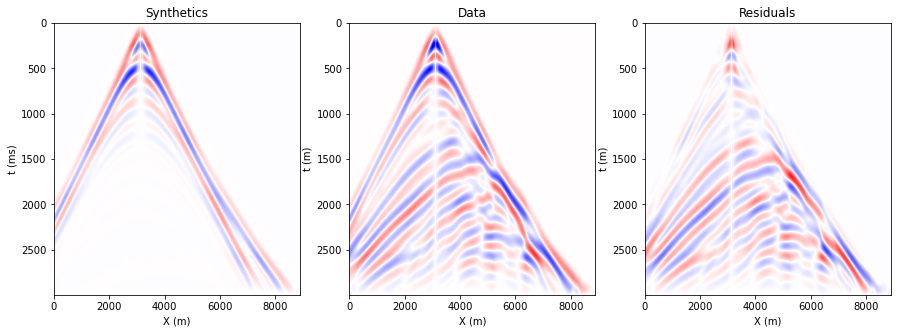

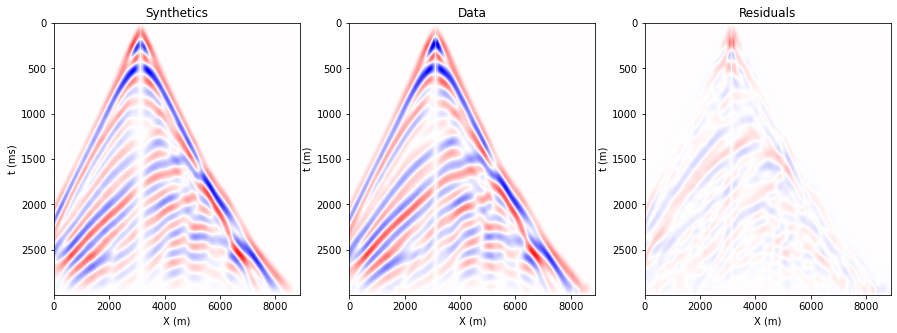

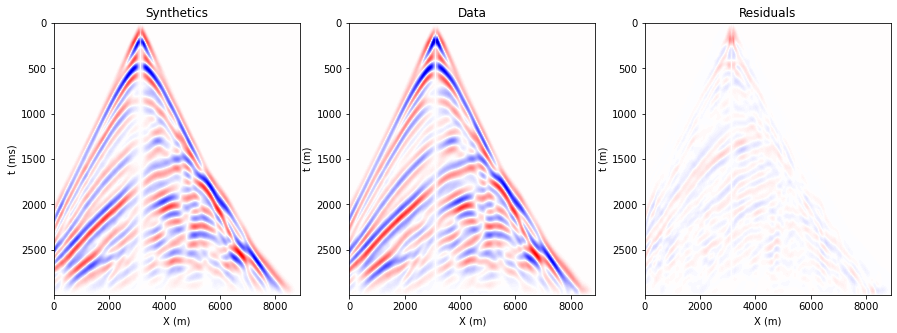

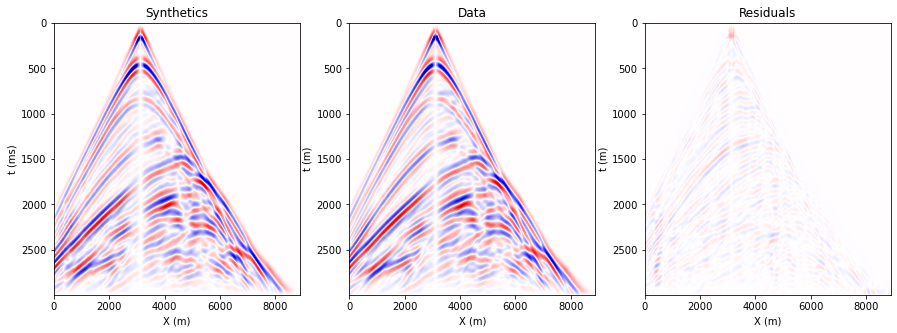

In [92]:

ntraces=nrecs*3
x1=0
x2=370
ampmin=-0.2
ampmax=0.2
for step in ["01","20","60","120"]:
    filename='compare_6_'+step+'.bin'
    traces=np.fromfile(filename, dtype=np.float32)
    traces=np.reshape(traces,(ntraces,n_samples))
    

    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 3, 1)
    extent = [x1, x2*dx, time[-1], time[0]]  # define extent
    ax1.imshow(traces.T[:,x1:x2], cmap="seismic",vmin=ampmin,vmax=ampmax,aspect='auto',extent=extent)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('t (ms)')
    ax1.set_title('Synthetics')
    ax1 = fig.add_subplot(1, 3, 2)
    extent = [x1, x2*dx, time[-1], time[0]]  # define extent
    ax1.imshow(traces.T[:,nrecs+x1:nrecs+x2], cmap="seismic",vmin=ampmin,vmax=ampmax,aspect='auto',extent=extent)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('t (m)')
    ax1.set_title('Data')
    ax1 = fig.add_subplot(1, 3, 3)
    extent = [x1, x2*dx, time[-1], time[0]]  # define extent
    ax1.imshow(traces.T[:,2*nrecs+x1:2*nrecs+x2], cmap="seismic",vmin=ampmin,vmax=ampmax,aspect='auto',extent=extent)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('t (m)')
    ax1.set_title('Residuals')


# Trace match

As a last check we look at how the trace match has improved. Notice that the final traces contain higher frequency because we have gradually increased the bandwidth of the the data and source as we progressed in the inversion.

Text(0.5, 0, 'Time(ms)')

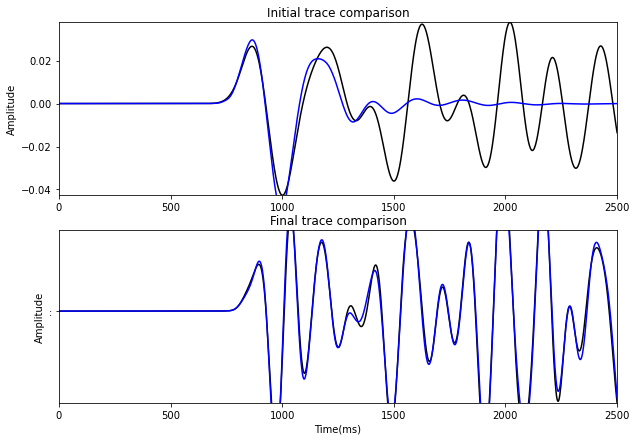

In [77]:
finaldatatrace=traces[nrecs+tracenum,:]
finalsyntrace=traces[tracenum,:]

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)
ax1.plot(time,datatrace,'black')
ax1.plot(time,syntrace,'blue')
ax1.set_xlim(0,2500)
ax1.set_ylim(np.min(datatrace),np.max(datatrace))
ax1.set_ylabel('Amplitude')
ax1.set_title('Initial trace comparison')

ax2 = fig.add_subplot(212)
ax2.plot(time,finaldatatrace,'black',":")
ax2.plot(time,finalsyntrace,'blue',":")
ax2.set_xlim(0,2500)
ax2.set_ylim(np.min(datatrace),np.max(datatrace))
ax2.set_ylabel('Amplitude')
ax2.set_title('Final trace comparison')
ax2.set_xlabel('Time(ms)')



# Final considerations

